# Capstone Project - The Battle of the Neighborhoods (Week 2)
## Recommending the Bicycle Lane for Reduction of Bicycle Accidents
### Applied Data Science Capstone by IBM/Coursera

## Introduction: Business Problem 

There are many cause of Bicycle accidents. therefore it’s hard to decide the place where should be installed (actually, it’s huge construction and takes huge money).and it’s important to be efficient. The data includes the Location of accidents, the number of accidents and victims. we will use this data and suggest the place for installation.

## Data

the Data of bicycle accidents can be found in “TAAS Caraccidents System” that is open source data center. if you want to reach this data, follow this link “http://taas.koroad.or.kr/”. this data is quite preprocessed, so we can save the time to preprocessing data.

## Import the Libraries

In [352]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
%matplotlib inline

## Download the Data

In [353]:
filepath = "C:\\Users\\lmj35\\Desktop\\IBM\\과제\\Chapter 9\\Final\\Dataset\\자전거 사고\\Bicycle Accident Data.csv"
bc_df = pd.read_csv(filepath, encoding='CP949')

In [354]:
bc_df.head(2)

,사고다발지FID,사고다발지ID,법정동코드,지점코드,시도시군구명,지점명,발생건수,사상자수,사망자수,중상자수,경상자수,부상신고자수,경도,위도,다발지역폴리곤
0,"161,307",2013099,1111013400,11110001,서울특별시 종로구1,서울특별시 종로구 경운동(안국역 부근),4,4,0,0,3,1,126.985544,37.576533,"{""type"":""Polygon"",""coordinates"":[[[126.9871445..."
1,"153,927",2013099,1111012300,11110002,서울특별시 종로구2,서울특별시 종로구 서린동(SK빌딩 부근),4,4,0,1,2,1,126.981070,37.570279,"{""type"":""Polygon"",""coordinates"":[[[126.9826705..."


In [355]:
bc_df.shape

(2718, 15)

## Preprocessing

In [356]:
# Renaming necessary column
bc_df.rename(columns={'사고다발지ID': 'Date',
                      '시도시군구명':'City_name',
                      '사상자수':'Num_total',
                      '발생건수':'Num_acc', '사망자수':'Num_dead',
                      '중상자수':'Num_serious',
                      '경상자수':'Num_light',
                      '경도':'longitude',
                      '위도':'latitude'}, inplace=True)
bc_df.head(2)

,사고다발지FID,Date,법정동코드,지점코드,City_name,지점명,Num_acc,Num_total,Num_dead,Num_serious,Num_light,부상신고자수,longitude,latitude,다발지역폴리곤
0,"161,307",2013099,1111013400,11110001,서울특별시 종로구1,서울특별시 종로구 경운동(안국역 부근),4,4,0,0,3,1,126.985544,37.576533,"{""type"":""Polygon"",""coordinates"":[[[126.9871445..."
1,"153,927",2013099,1111012300,11110002,서울특별시 종로구2,서울특별시 종로구 서린동(SK빌딩 부근),4,4,0,1,2,1,126.981070,37.570279,"{""type"":""Polygon"",""coordinates"":[[[126.9826705..."


In [357]:
# dropping unnecessary column
bc_df = bc_df.drop(['사고다발지FID',
                    '법정동코드',
                    '지점코드',
                    '지점명',
                    '부상신고자수',
                    '다발지역폴리곤'], axis=1)
bc_df.head(2)

,Date,City_name,Num_acc,Num_total,Num_dead,Num_serious,Num_light,longitude,latitude
0,2013099,서울특별시 종로구1,4,4,0,0,3,126.985544,37.576533
1,2013099,서울특별시 종로구2,4,4,0,1,2,126.981070,37.570279


In [358]:
# Selecting Only Seoul
bc_df = bc_df.loc[bc_df['City_name'].str.contains('서울')]

# remove unnecessary word
split = bc_df['City_name'].str.split(" ", n = 1, expand = True)
bc_df['City_name'] = split[1]

In [359]:
# remove number
import re

def removeNum(s):
    return re.compile('[가-힣]+').findall(s)[0]

bc_df['City_name'] = bc_df['City_name'].apply(removeNum)
bc_df.head()

,Date,City_name,Num_acc,Num_total,Num_dead,Num_serious,Num_light,longitude,latitude
0,2013099,종로구,4,4,0,0,3,126.985544,37.576533
1,2013099,종로구,4,4,0,1,2,126.981070,37.570279
2,2013099,종로구,5,5,0,2,2,127.015243,37.572994
3,2013099,중구,4,4,0,1,2,127.015435,37.569714
4,2013099,용산구,5,5,0,3,2,126.961790,37.522868


In [360]:
# Change to English
bc_df["City_name"].replace({"강남구": "Gangnam-gu",
                            "강동구": "Gangdong-gu",
                            "강북구": "Gangbuk-gu",
                            "강서구": "Gangseo-gu",
                            "관악구": "Gwanak-gu",
                            "광진구": "Gwangjin-gu",
                            "구로구": "Guro-gu",
                            "금천구": "Geumcheon-gu",
                            "노원구": "Nowon-gu",
                            "도봉구": "Dobong-gu",
                            "동대문구": "Dongdaemun-gu",
                            "동작구": "Dongjak-gu",
                            "마포구": "Mapo-gu",
                            "서대문구": "Seodaemun-gu",
                            "서초구": "Seocho-gu",
                            "성동구": "Seongdong-gu",
                            "성북구": "Seongbuk-gu",
                            "송파구": "Songpa-gu",
                            "양천구": "Yangcheon-gu",
                            "영등포구": "Yeongdeungpo-gu",
                            "용산구": "Yongsan-gu",
                            "은평구": "Eunpyeong-gu",
                            "종로구": "Jongno-gu",
                            "중구": "Jung-gu",
                            "중랑구": "Jungnang-gu"}, inplace=True)
bc_df.head()

,Date,City_name,Num_acc,Num_total,Num_dead,Num_serious,Num_light,longitude,latitude
0,2013099,Jongno-gu,4,4,0,0,3,126.985544,37.576533
1,2013099,Jongno-gu,4,4,0,1,2,126.981070,37.570279
2,2013099,Jongno-gu,5,5,0,2,2,127.015243,37.572994
3,2013099,Jung-gu,4,4,0,1,2,127.015435,37.569714
4,2013099,Yongsan-gu,5,5,0,3,2,126.961790,37.522868


## Analysis

## Load module and Libraries


In [361]:
%pip install geopy
from geopy.geocoders import Nominatim 


# library to handle requests
import requests 

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


# plotting library
%pip install folium
import folium


print('Folium installed')
print('Libraries imported.')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Folium installed
Libraries imported.


In [362]:
# Defining location
latitude = 37.5642135
longitude = 127.0016985

In [363]:
# Creating Map
venues_map = folium.Map(location=[latitude, longitude], zoom_start= 11)

# add circle mark
for lat, lng, label in zip(bc_df.latitude, bc_df.longitude, bc_df.City_name):
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

venues_map

## Scatter Plotting Serious injuries per Accident 

In [364]:
# Load Libraries and importing
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

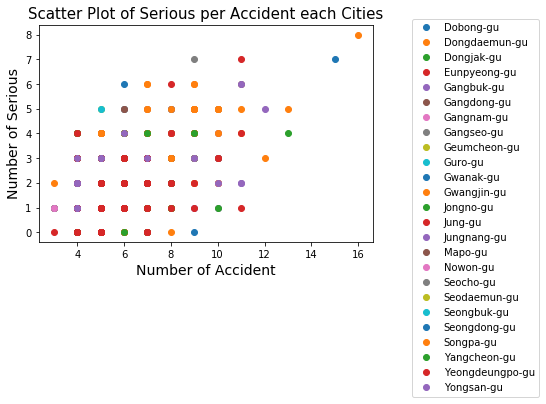

In [365]:
# Scatter plot with a different color by Cities
cities = bc_df.groupby('City_name')

fig, ax = plt.subplots()
for name, city in cities:
    ax.plot(city.Num_acc,
            city.Num_serious,
            marker='o',
            linestyle='',
            label=name)
# legend position
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Scatter Plot of Serious per Accident each Cities', fontsize=15)
plt.xlabel('Number of Accident', fontsize=14)
plt.ylabel('Number of Serious', fontsize=14)
plt.show()

### it looks confusing.. So we change it to Geo-HeatMap

## Geo-HeatMap plot

In [366]:
# Defining base Map
gh_map = folium.Map(location=[37.5642135, 127.0016985], control_scale=True, zoom_start=11)

In [367]:
# Creating Geo-heatMap
from folium.plugins import HeatMap

HeatMap(data=bc_df[['latitude','longitude','Num_acc']].\
        groupby(['latitude','longitude']).sum().reset_index().\
        values.tolist(),radius=8, max_zoom=13).add_to(gh_map)
gh_map

### We can check the Potential Accident place by click

In [368]:
# If you click it makes popup marker 'Potential Accident Location'
gh_map.add_child(folium.ClickForMarker(popup='Potential Accident Location'))

## Finding Accident more than 8times 

In [369]:
bc_df2 = bc_df[bc_df.Num_acc > 8]
bc_df2.head()

,Date,City_name,Num_acc,Num_total,Num_dead,Num_serious,Num_light,longitude,latitude
24,2013099,Gwangjin-gu,10,10,0,5,5,127.071003,37.540501
38,2013099,Dongdaemun-gu,9,9,0,6,3,127.051284,37.568055
39,2013099,Dongdaemun-gu,9,9,1,3,4,127.036931,37.577689
51,2013099,Jungnang-gu,10,10,0,1,9,127.081399,37.595552
64,2013099,Dobong-gu,10,10,0,5,2,127.043881,37.671347


### Adding Blue circles

In [370]:
# add circle mark
for lat, lng, label in zip(bc_df2.latitude, bc_df2.longitude, bc_df2.City_name):
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(gh_map)
    
gh_map

## Finding Accident more than 5 serious injuries

In [371]:
bc_df3 = bc_df[bc_df.Num_serious > 5]
bc_df3.head()

,Date,City_name,Num_acc,Num_total,Num_dead,Num_serious,Num_light,longitude,latitude
22,2013099,Gwangjin-gu,7,7,0,6,1,127.088548,37.553411
38,2013099,Dongdaemun-gu,9,9,0,6,3,127.051284,37.568055
186,2013099,Gangdong-gu,11,11,0,6,4,127.138778,37.533513
941,2015046,Seongdong-gu,6,7,0,6,1,127.058505,37.542782
953,2015046,Gwangjin-gu,7,7,0,6,1,127.083673,37.536648


### Adding red circles

In [372]:
# add circle mark
for lat, lng, label in zip(bc_df3.latitude, bc_df3.longitude, bc_df3.City_name):
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        fill=True,
        color='red'
        ).add_to(gh_map)

gh_map

## Choropleth Map

In [373]:
# Load
import requests
import json
from pandas.io.json import json_normalize
import os
import webbrowser


# Load Json file
geo_path = 'C:\\Users\\lmj35\\Desktop\\IBM\\과제\\Chapter 9\\Final\\Dataset\\json\\skorea_municipalities_geo_simple.json'
geo_data = json.load(open(geo_path, encoding='utf-8'))

print('completed!')

completed!


In [379]:
# Getting sum of each Cities
bc_df4 = bc_df.groupby(['City_name']).sum()
bc_df4 = bc_df4.drop(["longitude", "latitude","Date"], axis=1)
bc_df4.reset_index(inplace=True)
bc_df4.head()

,City_name,Num_acc,Num_total,Num_dead,Num_serious,Num_light
0,Dobong-gu,196,199,4,78,74
1,Dongdaemun-gu,531,554,5,170,288
2,Dongjak-gu,152,170,5,49,88
3,Eunpyeong-gu,214,224,3,65,108
4,Gangbuk-gu,182,198,2,68,115


In [380]:
C_map = folium.Map(location=[latitude,longitude], zoom_start=11)

C_map.choropleth(geo_data = geo_data,
                data = bc_df4,
                columns=['City_name','Num_acc'],
                fill_color='BuPu',
                fill_opacity=.5,
                highlight=True,
                key_on='feature.properties.name_eng'
                )

folium.LayerControl().add_to(C_map)

In [381]:
# Adding Circle in Choropleth map
bc_df5 = bc_df.groupby(['City_name']).mean()
bc_df5.reset_index(inplace=True)

for lat, lng, label in zip(bc_df5.latitude, bc_df5.longitude, bc_df5.City_name):
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        fill=True,
        color='red'
        ).add_to(C_map)
C_map

In [382]:
# Find Biggest Num_acc City
print(bc_df4.loc[bc_df4['Num_acc'] == bc_df4['Num_acc'].max()])

    City_name  Num_acc  Num_total  Num_dead  Num_serious  Num_light
21  Songpa-gu      889        941         7          316        458


In [383]:
# Find top5 Num_acc City
bc_df4.sort_values(by=['Num_acc'],axis=0, ascending=False).head()

,City_name,Num_acc,Num_total,Num_dead,Num_serious,Num_light
21,Songpa-gu,889,941,7,316,458
23,Yeongdeungpo-gu,555,612,5,157,329
1,Dongdaemun-gu,531,554,5,170,288
14,Jungnang-gu,393,417,2,118,188
11,Gwangjin-gu,318,333,3,135,151


## Results and Discussion

there are various analysis at this case. when we see the Scatter plot first, we can find it simply scattered evenly. becaues it is the marker that the accident are happened, not the number of the accident. So, i also plotted Geo-HeatMap. then we could find the region Songpa-gu, Gwangjin-gu, Yeongdeungpo-gu, Dongdaemun-gu, Jungnang-gu thoes are concentrated on the Accident. Additionally, Extracting the data that is the location happend more than 9 accidents. And it was added in Geo-HeatMap. then we had also found the place thoes concentrated on accident. Songpa-gu, Gwangjin-gu, Yeongdeungpo-gu, Dongdaemun-gu, Jungnang-gu. So, i also plotted Geo-HeatMap. then we could find the region Songpa-gu, Gwangjin-gu, Yeongdeungpo-gu, Dongdaemun-gu, Jungnang-gu thoes are concentrated on the Accident. Additionally, Extracting the data that is the location happend more than 9 accidents. And it was added in Geo-HeatMap. then we had also found the place thoes concentrated on accident.
Songpa-gu, Gwangjin-gu, Yeongdeungpo-gu, Dongdaemun-gu, Jungnang-gu. And again, I checked the Data that location happen the serious injuries more than 5 times. it had also found at same location. Finally, I plotted Choropleth Map to find the most common region at accident. then we could find the Songpa-gu is the most common region obviously. Collecting the data top 5 region of the number of accidents, the 1st is Songpa-gu, 2nd is Yeungdeungpo-gu 3rd is Dongdaemun-gu, 4th is Jungnang-gu. 5th is Gwangjin-gu.

## Conclusion

Based on Data, I thought it is proper to connect the location where the accidents happened frequently for installing bicycle lane. So I selected the location where accidents happened more than 9 times and found the street where accident happened, There were some times accident in same street but these are different part of street. So, I recommend to install the bicycle lane along with that street. it is efficient and economical to install the bicycle lane. And definitely, it helps to reduce the ratio of bicycle accident.